# Project Title
###  Linus Tech Tips Forum Cinebench Ergebnisse (Max Hammer, Date)

#### Project Summary
--describe your project at a high level--

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data (perform EDA, provide error handlings, unit tests, data quality tests, etc)
* Step 3: Define the Data Model/ Null/Alternative Hypothesis
* Step 4: Show the Model of  Data and any conclutions
* Step 5: Complete Project Write Up

In [1]:
# Do all imports and installs here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import unittest
import datetime

### Step 1: Scope the Project and Gather Data

#### Scope 
Explain what you plan to do in the project in more detail. What data do you use? What is your end solution look like? What tools did you use? etc>

#### Describe and Gather Data 
Describe the data sets you're using. Where did it come from? What type of information is included? 

In [2]:
# Read in the data here
multithread_data = pd.read_csv("Linus tech tips Cinebench R15 scores - CPU muti thread.csv")
singlethread_data = pd.read_csv("Linus tech tips Cinebench R15 scores - CPU single thread.csv")

cpu_data = pd.read_csv("cpus.csv")

In [3]:
# remove unnecessary columns
multithread_data = multithread_data.drop(["Name", "extra info"], axis=1)
singlethread_data = singlethread_data.drop(["Name", "Extra Info"], axis=1)
cpu_data = cpu_data.drop("Unnamed: 0", axis=1)

In [4]:
# map the names from the ltt forum to the name format from techpowerup
def map_intel_name(name):
  template = "Core {}-{}"
  split = name.split(' ')
  return template.format(split[2].lower(), split[3])

def multiprocessor_remove(name):
  return name.split('x ')[1]

def remove_amd(name):
  return name.split('AMD ')[1]

def remove_intel(name):
  return name.split('Intel ')[1]

def format_epy(name):
  return "EPYC {}".format(name.split('Epyc ')[1])

def map_name(name):
  intel_core = re.compile('Intel Core I\d')
  multiprocessor = re.compile('^\dx')
  amd = re.compile('^AMD')
  intel = re.compile('^Intel')
  epys = re.compile('^Epyc')
  if intel_core.match(name):
    return map_intel_name(name)
  if multiprocessor.match(name):
    name = multiprocessor_remove(name)
  if amd.match(name):
    name = remove_amd(name)
  if intel.match(name):
    name = remove_intel(name)
  return name

print(map_name("Intel Core I9 9900K"))
print(map_name("Ryzen Threadripper 1950X"))

multithread_data['CPU'] = multithread_data['CPU'].map(map_name)
singlethread_data['CPU'] = singlethread_data['CPU'].map(map_name)

print(multithread_data)

Core i9-9900K
Ryzen Threadripper 1950X
      Position                 CPU Clock Speed  Score (cb)
0            1  Xeon Platinum 8168     3.49ghz        8205
1            2           Epyc 7601      2.2ghz        6873
2            3        Xeon 8357 V3      2.5ghz        6139
3            4  Xeon Platinum 8168      2.7ghz        5926
4            5     Xeon E5 2696 V4      2.2ghz        5713
...        ...                 ...         ...         ...
1500      1502             A6 1450        1ghz          35
1501      1503               E-300      1.3ghz          31
1502      1504       Sempron 3000+    1.795ghz          23
1503      1505           Atom N450    1.667ghz          22
1504      1506                C-50    1.013ghz          20

[1505 rows x 4 columns]


In [5]:
# Sanitize clocks on cou base stats
def remove_MHz(clk):
  num = pd.to_numeric(clk.split(' MHz')[0])
  return num / 1000

def remove_GHz(clk):
  return pd.to_numeric(clk.split('GHz')[0])

def map_clk_speed(clk):
  mhz_regex = re.compile('^\d{3,} MHz$')
  if mhz_regex.match(clk):
    return remove_MHz(clk)
  return remove_GHz(clk)

cpu_data['minclock'] = cpu_data['minclock'].map(map_clk_speed)
cpu_data['maxclock'] = cpu_data['maxclock'].map(map_clk_speed)

cpu_data['cores'] = pd.to_numeric(cpu_data['cores'])
cpu_data['threads'] = pd.to_numeric(cpu_data['threads'])

In [6]:
# Remove ghz from clock speed on ltt dataset
def remove_ghz(clk):
  return clk.split('ghz')[0]

multithread_data['Clock Speed'] = pd.to_numeric(multithread_data['Clock Speed'].map(remove_ghz))
singlethread_data['Clock Speed'] = pd.to_numeric(singlethread_data['Clock Speed'].map(remove_ghz))

In [7]:
# extract only year from release date
def extract_year(date):
  split = date.split(' ')
  return pd.to_numeric(split[-1])

cpu_data['release'] = cpu_data['release'].map(extract_year)

### Step 2: Explore and Assess the Data
#### Explore the Data 
Identify data quality issues, like missing values, duplicate data, etc.

#### Cleaning Steps
Document steps necessary to clean the data

### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
Map out the conceptual data model and explain why you chosen that model

#### 3.2 Hypothesis Tests
provide needed statistiks with explonation and answer to your business questions for the analysis

In [8]:
# Create Overclock Dataset
overclock_data = pd.DataFrame()

for idx,row in multithread_data.iterrows():
  base_entry = cpu_data[cpu_data['name'] == row['CPU']]
  if base_entry.empty:
    continue
  new_entry = {'cpu':row['CPU'], 'cores':base_entry['cores'].values[0],'threads':base_entry['minclock'].values[0], 'base_clk':base_entry['minclock'].values[0], 'boost_clk':base_entry['maxclock'].values[0], 'oc_clk':row['Clock Speed'], 'release':base_entry['release'].values[0]}
  
  if idx == 0:
    overclock_data = pd.DataFrame.from_dict(new_entry)
  else:
    overclock_data = overclock_data.append(new_entry, ignore_index=True)

overclock_data = overclock_data.assign(oc_diff=lambda x: x['oc_clk'] - x['base_clk'])
overclock_data = overclock_data.assign(oc_boost_diff=lambda x: x['oc_clk'] - x['boost_clk'])
overclock_data.head()


,cpu,cores,threads,base_clk,boost_clk,oc_clk,release,oc_diff,oc_boost_diff
0,Core i9-7920X,12.0,2.9,2.9,4.4,4.8,2017.0,1.9,0.4
1,Core i9-7940X,14.0,3.1,3.1,4.4,4.2,2017.0,1.1,-0.2
2,Core i9-7960X,16.0,2.8,2.8,4.4,4.2,2017.0,1.4,-0.2
3,Core i9-7920X,12.0,2.9,2.9,4.4,4.8,2017.0,1.9,0.4
4,Core i9-7900X,10.0,3.3,3.3,4.5,5.1,2017.0,1.8,0.6


In [9]:
# Perform EDA
mean_oc_diff = np.mean(overclock_data.oc_diff)
median_oc_diff = np.mean(overclock_data.oc_diff)
std_dev_oc_diff = np.std(overclock_data.oc_diff)

mean_oc_boost_diff = np.mean(overclock_data.oc_boost_diff)
median_oc_boost_diff = np.mean(overclock_data.oc_boost_diff)
std_dev_oc_boost_diff = np.std(overclock_data.oc_boost_diff)

print('Mean of oc clock difference to base clock: {}GHz'.format(mean_oc_diff))
print('Median of oc clock difference to base clock: {}GHz'.format(median_oc_diff))
print('Standard deviation oc vs base clock difference: ', std_dev_oc_diff)

print('Mean of oc clock difference to boost clock: {}GHz'.format(mean_oc_boost_diff))
print('Median of oc clock difference to boost clock: {}GHz'.format(median_oc_boost_diff))
print('Standard deviation oc vs boost clock difference: ', std_dev_oc_boost_diff)

Mean of oc clock difference to base clock: 0.9476444866920153GHz
Median of oc clock difference to base clock: 0.9476444866920153GHz
Standard deviation oc vs base clock difference:  0.6261307376311162
Mean of oc clock difference to boost clock: 0.5594743346007605GHz
Median of oc clock difference to boost clock: 0.5594743346007605GHz
Standard deviation oc vs boost clock difference:  0.6941850806142198


In [10]:
# Show outliers
print('Outliers_min',overclock_data.oc_diff.min())
print('Outliers_max',overclock_data.oc_diff.max())

print('Outliers_min_boost',overclock_data.oc_boost_diff.min())
print('Outliers_max_boost',overclock_data.oc_boost_diff.max())



Outliers_min -0.2959999999999998
Outliers_max 2.777
Outliers_min_boost -1.6
Outliers_max_boost 2.6900000000000004


### Step 4: Show your solution: the Model of  Data and any conclutions 
#### 4.1 Create graphics, any needed queris to visualise your solution


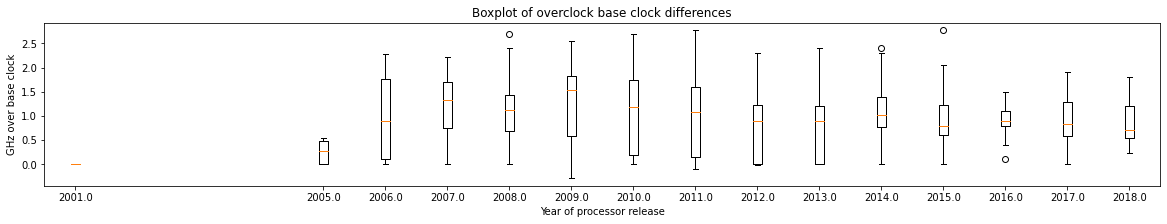

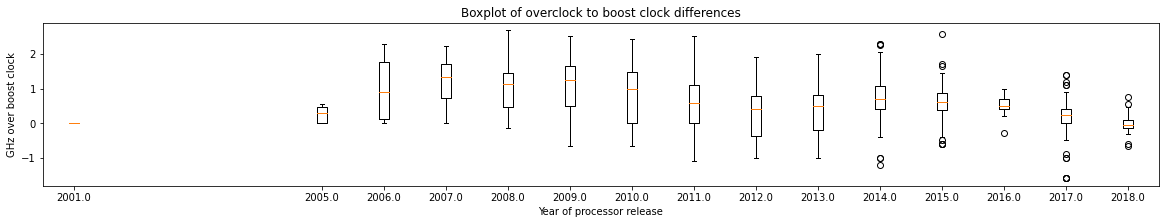

In [11]:
# Boxplot per year oc results
release_years = overclock_data['release'].unique()
release_years.sort()

plt.figure(figsize=(20,3))
plt.title('Boxplot of overclock base clock differences')
for year in release_years:
  plt.boxplot(overclock_data[overclock_data['release'] == year]['oc_diff'], positions=[year])
plt.ylabel('GHz over base clock')
plt.xlabel('Year of processor release')
plt.show()

plt.figure(figsize=(20,3))
plt.title('Boxplot of overclock to boost clock differences')
for year in release_years:
  plt.boxplot(overclock_data[overclock_data['release'] == year]['oc_boost_diff'], positions=[year])
plt.ylabel('GHz over boost clock')
plt.xlabel('Year of processor release')
plt.show()

# Result interpretation
The difference in outliers, when comparing the plots for base clock and boost clock, is mainly due to the nature of Intel's boost especially on many core processors. 

As an example the i9-9900K:
  Intel advertises a boost clock ofa 5GHz, but only for a load of up to 2 cores.<br>
  For any load of up to 4 cores, the processor's boost clock is lowered, down to 4.8GHz.<br>
  Finally the boost clock for a load of 6 and more cores, the boost clock is 4.7GHz

The data used for overclock results is about a multi core test and the many core processors are not capable of running their top boost clock on all of their cores. Even in an overclocked state. The later plot shows many outliers on the low end of the chart, these would be bad performing 7th generation high end desktop chips from Intelm like the i9 7980XE.

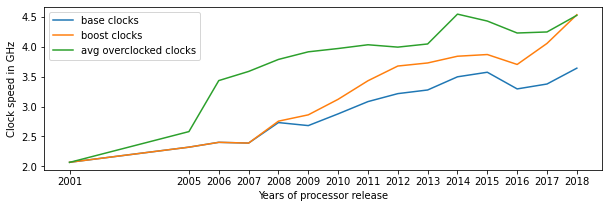

In [12]:
# Evolution of base clock in relation to boost clock, using the mean
base_clocks = []
boost_clocks = []
oc_clocks = []
for year in release_years:
  base_clocks.append(overclock_data[overclock_data['release'] == year]['base_clk'].mean())
  boost_clocks.append(overclock_data[overclock_data['release'] == year]['boost_clk'].mean())
  oc_clocks.append(overclock_data[overclock_data['release'] == year]['oc_clk'].mean())

plt.figure(figsize=(10,3))
plt.plot(release_years,base_clocks, label='base clocks')
plt.plot(release_years,boost_clocks, label='boost clocks')
plt.plot(release_years, oc_clocks, label='avg overclocked clocks')
plt.xticks(release_years)
plt.ylabel('Clock speed in GHz')
plt.xlabel('Years of processor release')
plt.legend()
plt.show()

# Result interpretation
This shows the trend towards more cores, which cannot sustain a high base clock due to the required power and therefore required cooling. But the graph shows at the same time, that the clock speeds for single or dual core loads continue to increase.

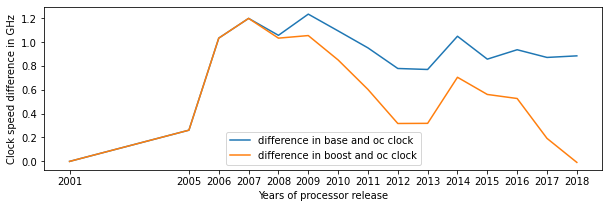

In [14]:
base_diff = []
boost_diff = []
for year in release_years:
  base_diff.append(overclock_data[overclock_data['release'] == year]['oc_diff'].mean())
  boost_diff.append(overclock_data[overclock_data['release'] == year]['oc_boost_diff'].mean())

plt.figure(figsize=(10,3))
plt.plot(release_years,base_diff, label='difference in base and oc clock')
plt.plot(release_years,boost_diff, label='difference in boost and oc clock')
plt.xticks(release_years)
plt.ylabel('Clock speed difference in GHz')
plt.xlabel('Years of processor release')
plt.legend()
plt.show()

# Result interpretation

The graph shows that, while the difference in base clock and oc clock are relatively stable, the difference between the maximum  boost clocks and the achieved overclocked results are very small.

This shows a trend in the development of CPUs, that the manufacturers are pushing for the highest possible clock speeds and therefore highest possible performance. Due to thermal or power limitations, these maximum clock speeds, are not used for loads of more than 2 cores. The overclocking results, therefore show that the advertised boost clock speeds can be achieved in an all core load and aren't the ceiling. The graph also shows, that the headroom for overclocking is already very slim on modern chips. 

Due to the overclocking dataset being during an all-core load and the CPU stat dataset showing maximum boost, which (most of the time) gives a frequency for at most 2 cores, it would also be feasable to conclude, that newer CPUs are difficult to overclock further than their advertised maximum boost clock.

Although the difference between boost and overclocked speeds seem to be very low, the workload for the overclocked results is for all cores, the CPU has access to. The advertised boost clocks, which the CPU stat dataset has is only applicable to at, most 2 cores. This means, although the results don't look like it, there is still overclocking done, because the frequency of all cores is different, than the advertised frequency for a load with the amount of cores.

#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the dataframes. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
Run Quality Checks

In [ ]:
# Perform quality checks here

#### 4.3 Data dictionary 
Create a data dictionary for your data model. For each field, provide a brief description of what the data is and where it came from. You can include the data dictionary in the notebook or in a separate file.

#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies, algorithms, methodes for the project.
* Propose how often the data should be updated and why. What tools you are used for data simulation in case if it is needed.
* Write a description of how you would approach the problem differently if you have another data model or additinal information